# Tutorial 1

In this session, we will look at the wikileaks dataset and learn how to start gathering statistics about the dataset, preprocess the emails and extract useful information.

## Loading JSON file

In the folder you will find a json file.

In [64]:
import pandas as pd

def load_json_data(path_to_file):
    data_DF = pd.read_json(path_to_file,encoding='ascii')
    data_DF['from'] = data_DF['from'].str.lower()
    data_DF['body'] = data_DF['body'].apply(lambda x: " ".join(str(x).split()))
    return data_DF

In [86]:
data = load_json_data("clean_json.json")

/Users/skynet/anaconda/envs/hackzh/lib/python3.5/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


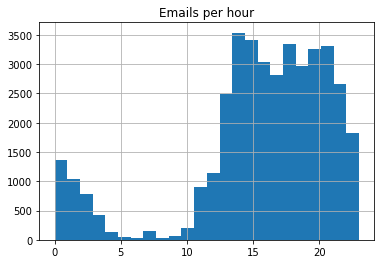

In [89]:
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import string

stop_words_list = stopwords.words('english') + list(string.punctuation) + \
["I","PM","2016","AM","RE:","The", "To:", "Sent:", "From:", "Subject:","--", "-"]

class Dataset(object):
    def __init__(self, dataframe):
        self.data = dataframe
        self.user_emails = list(set(self.data['from']))
        self._generate_email2name()
        self.word_count = Counter()

    def _generate_email2name(self):
        self.EMAIL2NAME = defaultdict(list) # in case there are aliases
        user_emails = self.data['from']
        user_names = self.data['from_name']
        receivers = self.data['to']
        for email, name in zip(list(user_emails),list(user_names)):
            email = email.lower()
            name = name.replace('"','')
            if name not in self.EMAIL2NAME[email]:
                self.EMAIL2NAME[email].append(name)

        receivers_emails = []
        for receiver in list(receivers):
            for name, email in receiver:
                email = email.lower()
                name = name.replace('"','')
                if name not in self.EMAIL2NAME[email]:
                    self.EMAIL2NAME[email].append(name)

    def get_top_spammers(self, ntop=9999):
        print("Count \t Email \t \t \t Name")
        list_spammers = []
        printout = 0
        for a in self.data.groupby(self.data['from'])['from'].count()\
                                        .reset_index(name='count') \
                                        .sort_values(['count'], ascending=False)\
                                        .iterrows():
                _, email = a
                if printout < ntop:
                    print("%i \t %s \t %s" %(email['count'],email['from'],self.EMAIL2NAME[email['from']][0]))
                    printout += 1
                    list_spammers.append([email['count'],email['from'],self.EMAIL2NAME[email['from']][0]])
        return list_spammers
            
    def get_total_vocabulary(self):
        #returns a dict of emails and their respective vocab
        self.vocabulary = self.data['body'].str.cat(sep=' ') + self.data['subject'].str.cat(sep=' ')
        return self.vocabulary
    
    def get_vocabulary_count(self,stop_words=False):
        if stop_words:
            self.word_count = Counter([x for x in self.vocabulary.split(' ') if x not in stop_words_list])
        else:
            self.word_count = Counter([x for x in self.vocabulary.split(' ')])

        return self.word_count
    
    def get_top_words(self,stop_words=False):
        if len(self.word_count.keys())==0:
            self.get_vocabulary_count(stop_words=stop_words)
        print('Word \t Count')
        for a,b in self.word_count.most_common(20):
            print('%s \t %i)' %(a, b))
        return self.word_count.most_common(20)
        
    def generate_reduced_dataset(self, list_of_users):
        pass
        #returns a smaller dataframe

def plot_time(dataframe):
       new = dataframe[['date']]
       new['hour'] = pd.DatetimeIndex(new['date']).hour
       new['hour'].hist(bins=24)
       plt.title('Emails per hour')
        
DataObject = Dataset(data)
plot_time(DataObject.data)
#print(DataObject.data.head())

Let's explore this dataset a bit.

1. For example, who sends out most emails?
2. Which words are most common?
3. Around when were emails most received (by day of the week and hour)

In particular, how can we improve the output of question 2 (if the most common words aren't particularly interesting?)

In [90]:
DataObject = Dataset(data)
tab = DataObject.get_top_spammers(ntop=50)

DataObject.get_total_vocabulary()

word_count = DataObject.get_top_words(stop_words=True)

Count 	 Email 	 	 	 Name
1780 	 mirandal@dnc.org 	 Miranda, Luis
1518 	 hendricksl@dnc.org 	 Hendricks, Lauren
1319 	 brinsterj@dnc.org 	 Brinster, Jeremy
1110 	 walkere@dnc.org 	 Walker, Eric
1104 	 dncpress@dnc.org 	 DNC Press
1098 	 sargem@dnc.org 	 Sarge, Matthew
1077 	 freundlichc@dnc.org 	 Freundlich, Christina
1032 	 comers@dnc.org 	 Comer, Scott
892 	 garciaw@dnc.org 	 Garcia, Walter
889 	 bhatnagara@dnc.org 	 Bhatnagar, Akshai
860 	 paustenbachm@dnc.org 	 Paustenbach, Mark
852 	 manriquezp@dnc.org 	 Manriquez, Pablo
833 	 kaplanj@dnc.org 	 Jordan Kaplan
788 	 crystala@dnc.org 	 Crystal, Andy
757 	 sorbies@dnc.org 	 Sorbie, Sean
743 	 weis@dnc.org 	 Yen
741 	 bennette@dnc.org 	 Bennett, Eric
701 	 parrishd@dnc.org 	 Parrish, Daniel
696 	 palermor@dnc.org 	 Palermo, Rachel
690 	 lykinst@dnc.org 	 Lykins, Tyler
596 	 pricej@dnc.org 	 Price, Jenna
596 	 bonoskyg@dnc.org 	 Bonosky, Garret
577 	 banfillr@dnc.org 	 Banfill, Ryan
529 	 =?us-ascii?q?white_house_press_office?=
	<noreply

Now let's try to get a feeling of what these people are talking about.

In this example, we will do a simple topic mining model and use spacy to pick up on relevant entities.

In particular:
1. Aggregate the communication between two people
1. Perform topic modelling on the subset exchanged emails
2. Perform named entity extraction on the subset

The output of this task is to find pairs of people and the keywords/topics they are talking about in their emails.

In [93]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nlp = spacy.load('en')
list_of_entities = nlp.entity.cfg[u'actions']['1']
relevant_entities = ['EVENT','FAC','GPE','LAW','NORP','LOC','ORG','PRODUCT', 'PERSON']

def clean_text(text):
    return text

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            topics.append(feature_names[i])
        
    return topics

def get_keywords(sentence):
    keywords = defaultdict(list)
    doc = nlp(sentence)
    for ent in doc.ents:
        if ent.label_ in relevant_entities:
            keywords[ent.label_].append(ent.text)
    return keywords

def get_topics(emails):
    # eats a list of emails and returns 3 topics 
    # NMF is able to use tf-idf
    temp = []
    for em in emails:
        try:
            accum = [a for a in em[0].split('.')]
            temp += accum
        except:
            continue
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=False)
    tfidf = tfidf_vectorizer.fit_transform(temp)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(stop_words='english', lowercase=False)
    tf = tf_vectorizer.fit_transform(temp)
    tf_feature_names = tf_vectorizer.get_feature_names()

    no_topics = 5

    # Run NMF
    nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    # Run LDA
    lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    no_top_words = 3
    topics1 = display_topics(nmf, tfidf_feature_names, no_top_words)
    topics2 = display_topics(lda, tf_feature_names, no_top_words)
    return topics1 + topics2

class user(object):
    def __init__(self, data, email):
        self.user = email
        self.emails = data.data.loc[data.data['from']==self.user]['body']
        self.vocabulary_raw = self.get_vocabulary(data)
        self.keywords = defaultdict(list)
        self.correspondents_count = Counter()
        self.correspondents_emails = defaultdict(list)
        self.correspondents_keywords = defaultdict(dict)
        self.get_connections(data)
        self.correspondents_topics = defaultdict(list)
        self.get_topics_correspondents()
        self.connections = self.correspondents_count.keys()

    def get_vocabulary(self, data):
        return data.data.loc[data.data['from']==self.user]['body'].str.cat(sep=' ')
    
    def get_connections(self,data):
        # return person, number of emails, top entities
        self.keywords_per_receiver = defaultdict(dict)
        for row in data.data.loc[data.data['from']==self.user].itertuples():
            indx, body, date, sender, from_name, subject, corres = row
            #try:
            if len(corres) == 0:
                continue
            for r in corres[0]:
                    if '@' not in r:
                        pass
                    else:
                        r = r.lower()
                        self.correspondents_count[r] += 1
                        self.correspondents_emails[r].append([clean_text(body)])
                        keywords = get_keywords(clean_text(body))
                        
                        if r not in self.correspondents_keywords.keys():
                            for key in relevant_entities:
                                self.correspondents_keywords[r][key] = []
                        for key in keywords.keys():
                            if key in relevant_entities:
                                self.correspondents_keywords[r][key] += keywords[key]
                                
        for receiver in self.correspondents_emails.keys():
            for row in data.data.loc[data.data['from']==receiver].itertuples():
                indx, body, date, sender, from_name, subject, corres = row
                if len(corres) == 0:
                    continue
                if self.user not in corres[0]:
                    continue
                    
                self.correspondents_emails[receiver].append(str(body))
                keywords = get_keywords(body)
                        
                if receiver not in self.correspondents_keywords.keys():
                    #instanciate dictionary
                    for key in relevant_entities:
                        self.correspondents_keywords[receiver][key] = []
                        
                for key in keywords.keys():
                    if key in relevant_entities:
                        self.correspondents_keywords[receiver][key] += keywords[key]
    
    def get_topics_correspondents(self):
        for corres in self.correspondents_keywords.keys():
            try:
                topics = get_topics(userA.correspondents_emails[corres])
            except:
                topics = []
            counter = Counter(topics)
            self.correspondents_topics[corres] = counter.most_common(5)

In [94]:
userA = user(DataObject,"hrtsleeve@gmail.com")

In [95]:
import pickle   
    
tab = DataObject.get_top_spammers(ntop=50)
top_s = [a[1] for a in tab]

graph = []
for indx, email in enumerate(top_s[0:5]):
    userA = user(DataObject,email)
    for key in userA.correspondents_count.keys():
        graph.append({'email': email, 'correspondent': key, 'topics': userA.correspondents_topics[key], 'keywords': userA.correspondents_keywords[key], 'count': userA.correspondents_count[key]})
    
pickle.dump(graph, open('graph_topics_dict_t.pkl','wb'))

Count 	 Email 	 	 	 Name
1780 	 mirandal@dnc.org 	 Miranda, Luis
1518 	 hendricksl@dnc.org 	 Hendricks, Lauren
1319 	 brinsterj@dnc.org 	 Brinster, Jeremy
1110 	 walkere@dnc.org 	 Walker, Eric
1104 	 dncpress@dnc.org 	 DNC Press
1098 	 sargem@dnc.org 	 Sarge, Matthew
1077 	 freundlichc@dnc.org 	 Freundlich, Christina
1032 	 comers@dnc.org 	 Comer, Scott
892 	 garciaw@dnc.org 	 Garcia, Walter
889 	 bhatnagara@dnc.org 	 Bhatnagar, Akshai
860 	 paustenbachm@dnc.org 	 Paustenbach, Mark
852 	 manriquezp@dnc.org 	 Manriquez, Pablo
833 	 kaplanj@dnc.org 	 Jordan Kaplan
788 	 crystala@dnc.org 	 Crystal, Andy
757 	 sorbies@dnc.org 	 Sorbie, Sean
743 	 weis@dnc.org 	 Yen
741 	 bennette@dnc.org 	 Bennett, Eric
701 	 parrishd@dnc.org 	 Parrish, Daniel
696 	 palermor@dnc.org 	 Palermo, Rachel
690 	 lykinst@dnc.org 	 Lykins, Tyler
596 	 pricej@dnc.org 	 Price, Jenna
596 	 bonoskyg@dnc.org 	 Bonosky, Garret
577 	 banfillr@dnc.org 	 Banfill, Ryan
529 	 =?us-ascii?q?white_house_press_office?=
	<noreply

In [96]:
a = pickle.load(open('graph_topics_dict_t.pkl','rb'))

def get_top_words(dictionary, exclude=[]):
    all_words = dictionary['topics']
    for key in list(dictionary['keywords'].keys()):
        temp = []
        if len(dictionary['email'])==0:
            return 
        #all_words+= 
        temp = dictionary['keywords'][key]
        if len(temp) < 2:
            continue
        count = Counter(temp)
        print(count)
        for a, b in count.most_common(1): #for example 
            print(a)
            all_words.append(a)
            
    all_words = [a for a in all_words if a not in exclude]
    
    print('Email: ', dictionary['email'], 'To: ', dictionary['correspondent'],\
          'Words: ', all_words)

for e in a:
    exclude_words = [DataObject.EMAIL2NAME[e['email']][0], DataObject.EMAIL2NAME[e['correspondent']][0], e['email'], e['correspondent'],\
                    ] + DataObject.EMAIL2NAME[e['email']][0].split(',') + DataObject.EMAIL2NAME[e['correspondent']][0].split(',')
    get_top_words(e, exclude = exclude_words)

Counter({'Alvillar': 6, 'K.J.': 4, 'Bagchi': 2, 'Colorado': 1, 'Japan': 1, 'Freundlich': 1, 'KJ': 1, 'Hawaii': 1, 'Mon': 1, 'SF': 1, 'Guatemala': 1})
Alvillar
Counter({'John Zody': 13, 'Miranda': 12, 'Raul': 10, 'Walker': 8, 'Luis': 8, 'Christopher': 8, 'Christina Cc': 7, 'Eric': 7, 'Rebecca': 6, 'Alvillar': 6, 'Freundlich': 6, 'Luis Miranda': 5, 'Bagchi': 5, 'Dacey': 4, 'Helmstetter': 4, 'Maureen Garde': 3, 'Indiana Dems': 3, 'Raul Sent': 3, 'Luis Subject': 3, 'Zody': 2, 'Sanders': 2, 'Amy': 2, 'Amy Subject': 2, 'Jakubiec': 2, 'Matthew Sent': 2, 'Mom': 1, 'Lieu And': 1, 'Pablo Sent': 1, 'Ed': 1, 'MAZIE HIRONO Q': 1, 'Chair Emeritus': 1, 'Raul Subject': 1, 'Honda': 1, 'KJ': 1, 'Maureen Garde Subject': 1, 'Eric"': 1, 'Hirono': 1, 'Christina <FreundlichC@dnc.org>': 1, 'Alex Seitz-Wald': 1, 'Luis Sent': 1, 'K.J. Subject': 1, 'Amy Dacey': 1, 'Lieu': 1, 'Rebecca Sent': 1, "Ed O'Keefe": 1, "O'Keefe": 1, 'Manriquez': 1, 'Seitz': 1, 'Joe Pablo': 1, 'Mike Honda': 1, 'Alexander': 1, 'K.J. Sent':

Counter({'Obama’s': 7, 'Donna': 4, 'Donna Brazile': 4, 'Luis Miranda': 3, 'Bill Clinton': 2, 'Plouffe': 2, 'Miranda': 2, 'Bylaws Committee': 2, 'Rosenberg': 2, 'Brazile': 2, 'Clinton': 2, 'Obama': 2, 'Luis Subject': 2, 'Twitter': 2, 'Matthew Dowd': 1, 'David Simas': 1, 'David Axelrod': 1, 'Larry J. Sabato': 1, 'Donald Trump': 1, 'Luján': 1, 'McGinty': 1, 'Luis <MirandaL@dnc.org>': 1, 'Denis McDonough': 1, 'Dwight D. Eisenhower': 1, 'Simon Rosenberg': 1, 'Jim Roosevelt': 1, 'Charles E. Schumer': 1, 'Memo': 1, 'Josh Shapiro': 1, 'Lorraine Miller': 1, 'McDonough': 1, 'Barack Obama': 1, 'Alex Wagner': 1, 'John Bel Edwards': 1, 'David Plouffe': 1, 'Debbie Wasserman Schultz': 1, 'Marc E. Elias': 1, 'Jim Messina': 1, 'Medium': 1, 'Ben Ray Luján': 1, 'Ryan Banfill': 1, 'Barney Frank': 1, 'Hillary Clinton': 1, 'An Overview of the Democratic Delegate': 1, 'Sean Bartlett': 1, 'Luis': 1, 'Roberta Lange': 1, 'Steve': 1, 'Simas': 1, 'Rich Lowry': 1, 'George Stephanopoulos': 1, 'Reid’s': 1, 'Katie Mc

Email:  mirandal@dnc.org To:  larrygoldin@gci.net Words:  []
Counter({'Luis Subject': 1, 'Hadas': 1, 'Luis Miranda': 1, 'Hadas Gold': 1, 'Luis': 1, 'Miranda': 1})
Luis Subject
Counter({'DNC': 2, 'Democratic National Committee': 1, 'Hadas Gold Media': 1, 'Communications': 1})
DNC
Email:  mirandal@dnc.org To:  hgold@politico.com Words:  ['Luis Subject', 'DNC']
Counter({'Berns': 9, 'Ezra': 6, 'Lauren Hendricks': 6, 'Jeremy': 6, 'Michael Steele': 3, 'Ezra Sent': 3, 'Jeremy Sent': 3, 'Steele': 3, 'Brian Williams': 3, 'Jeremy Berns': 3, 'Steve Schmidt': 3, 'Corinne Matti Sent': 3, 'Weaver': 3})
Berns
Counter({'GOP': 9, 'Deutsch-Feldman': 6, 'MSNBC Indiana Primary': 3, 'Hendricks, Lauren <': 3, 'MSNBC Indiana Primary Coverage Watch': 3, 'MSNBC Indiana Primary Coverage': 3, 'Hendricks, Lauren Cc': 3})
GOP
Email:  hendricksl@dnc.org To:  mattic@dnc.org Words:  [('MIRANDA', 3), ('think', 2), ('voters', 2), ('know', 2), ('HEMMER', 2), 'Berns', 'GOP']
Counter({'Berns': 6, 'Brian Williams': 3, 'Mic